# MAT281 - Tarea 2

**Indicaciones**:

* En los **Ejercicio 1-8** puedes utilizar tanto `matplotlib` como `altair` según te parezca más conveniente o cómodo, en ambos casos cada gráfico debe tener elementos mínimos como:
    - Título
    - Nombre de los ejes, leyendas, etc. en formato _amigable_/_humano_, por ejemplo, si la columna del dataframe en cuestión tiene por nombre `casos_confirmados` se espera que el eje del gráfico tenga por nombre `Casos confirmados`.
    - Colores adecuados al tipo de datos.
    - Un tamaño adecuado para ver con facilidad en una pantalla con resolución HD o FullHD.
    - Cada vez que no se cumplan alguna de estos requerimientos se descontará __1 punto__ de la nota final.

* Para el **Ejercicio 9** es obligación utilizar `altair`.
* Cada ejercicio debe estar acompañado con una celda con comentarios o análisis que puedas desprender de los gráficos.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import ipywidgets as widgets

from datetime import date
from ipywidgets import interactive, interact

pd.set_option('display.max_columns', 999)
#alt.data_transformers.enable('data_server')
alt.data_transformers.disable_max_rows()
alt.themes.enable('opaque')

%matplotlib inline

**COVID-19 en Chile** 

En esta tarea exploraremos los datos de Covid-19 en Chile a profundidad. Las siguientes celdas cargarán los datos a utilizar en tu sesión. Es importante que leas la documentación de cada conjunto de datos para comprender las columnas.

In [2]:
start_date = pd.to_datetime("2020-04-13")

In [3]:
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto6
confirmados = (
    pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto6/bulk/data.csv")
    .rename(columns=lambda x: x.lower().replace(" ", "_"))
    .assign(fecha=lambda x: pd.to_datetime(x["fecha"]))
    .loc[lambda x: x["fecha"] >= start_date]
    .dropna()
    .astype({"casos_confirmados": np.float, "tasa": np.float})
)
display(confirmados.head())

,poblacion,casos_confirmados,fecha,region_id,region,provincia_id,provincia,comuna_id,comuna,tasa
0,247552.0,270.0,2020-04-27,15.0,Arica y Parinacota,151.0,Arica,15101.0,Arica,109.067994
1,247552.0,9138.0,2020-10-12,15.0,Arica y Parinacota,151.0,Arica,15101.0,Arica,3691.345657
2,247552.0,596.0,2020-05-29,15.0,Arica y Parinacota,151.0,Arica,15101.0,Arica,240.757497
3,247552.0,6131.0,2020-08-17,15.0,Arica y Parinacota,151.0,Arica,15101.0,Arica,2476.651370
4,247552.0,353.0,2020-05-11,15.0,Arica y Parinacota,151.0,Arica,15101.0,Arica,142.596303


In [4]:
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto19
activos = (
    pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto19/CasosActivosPorComuna.csv")
    .rename(columns=lambda x: x.lower().replace(" ", "_"))
    .loc[lambda x: x["codigo_comuna"].notnull()]
    .melt(id_vars=["region", "codigo_region", "comuna", "codigo_comuna", "poblacion"], var_name="fecha", value_name="casos_activos")
    .assign(fecha=lambda x: pd.to_datetime(x["fecha"]))
    .loc[lambda x: x["fecha"] >= start_date]
)


In [5]:
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto14
fallecidos = (
    pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo.csv")
    .rename(columns=lambda x: x.lower().replace(" ", "_"))
    .melt(id_vars=["region"], var_name="fecha", value_name="fallecidos")
    .assign(
        fecha=lambda x: pd.to_datetime(x["fecha"]),
    )
    .loc[lambda x: x["fecha"] >= start_date]
)

fallecidos.head()

,region,fecha,fallecidos
374,Arica y Parinacota,2020-04-13,1.0
375,Tarapacá,2020-04-13,0.0
376,Antofagasta,2020-04-13,1.0
377,Atacama,2020-04-13,0.0
378,Coquimbo,2020-04-13,0.0


In [6]:
# https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto10
fallecidos_etareo = (
    pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto10/FallecidosEtario.csv")
    .rename(columns=lambda x: x.lower().replace(" ", "_"))
    .melt(id_vars=["grupo_de_edad"], var_name="fecha", value_name="fallecidos")
    .assign(
        fecha=lambda x: pd.to_datetime(x["fecha"]),
        grupo_de_edad=lambda x: x["grupo_de_edad"].str.replace("<=39", "0-39")
    )
    .loc[lambda x: x["fecha"] >= start_date]
)

fallecidos_etareo.head()

,grupo_de_edad,fecha,fallecidos
28,0-39,2020-04-13,3
29,40-49,2020-04-13,2
30,50-59,2020-04-13,3
31,60-69,2020-04-13,12
32,70-79,2020-04-13,29


## Ejercicio 1

(10 puntos)

Mostrar cantidad de fallecidos la fecha por cada grupo etáreo.

In [7]:
display(fallecidos_etareo.groupby(["grupo_de_edad"]).sum())

,fallecidos
grupo_de_edad,
0-39,43042
40-49,65440
50-59,195061
60-69,406929
70-79,545399
80-89,492464
>=90,176174


**Comentarios:** Podemos ver que la mayor cantidad de fallecidos se concentra en personas mayores de 50 años. Que son teóricamente el grupo de mayor riesgo.

## Ejercicio 2

(10 puntos)

¿Qué tan variable es la población de las comunas de Chile? Considera utilizar un gráfico que resuma de buena forma la información sin agregar la variable de región o provincia.

In [8]:
comunas_ = activos["comuna"].unique()
com_aux = {"comuna": [], "poblacion": []}
for comuna_ in comunas_:
    if comuna_ not in com_aux["comuna"]:
        com_aux["comuna"].append(comuna_)
        pob = activos.query(f'comuna == "{comuna_}"')["poblacion"].unique()[0]
        com_aux["poblacion"].append(pob)
com_aux = pd.DataFrame(com_aux)
com_aux.head()

,comuna,poblacion
0,Arica,247552.0
1,Camarones,1233.0
2,General Lagos,810.0
3,Putre,2515.0
4,Alto Hospicio,129999.0


In [9]:
x_max = com_aux["poblacion"].max()
x_min = com_aux["poblacion"].min()
n = 150
X = np.linspace(x_min, x_max, n)
Y = []
for x in X:
    Y.append(com_aux.query(f"poblacion <= {x}").count()[0]/346)
Y = np.array(Y)

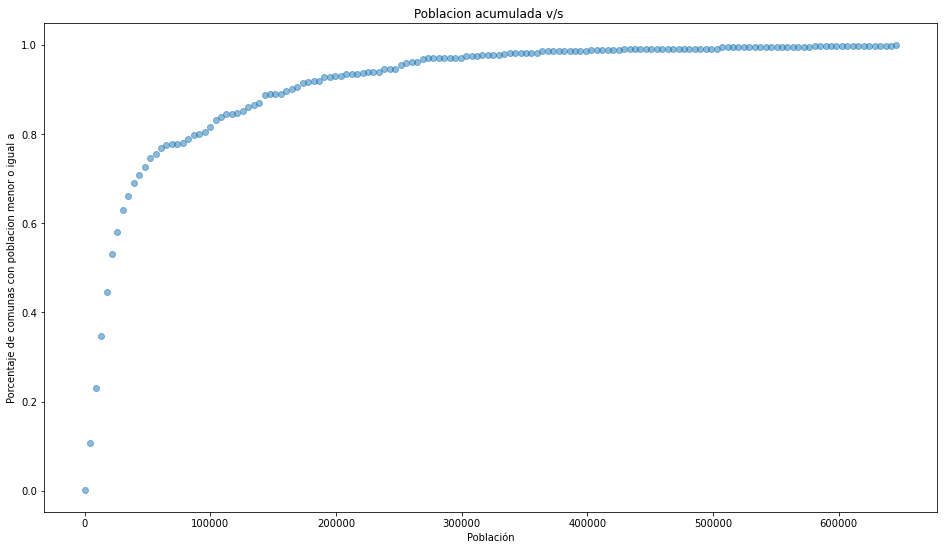

In [10]:
plt.figure(figsize = (16,9))
plt.scatter(X,Y, alpha = 0.5)
plt.xlabel("Población")
plt.ylabel("Porcentaje de comunas con poblacion menor o igual a")
plt.title("Poblacion acumulada v/s ")
plt.show()

In [11]:
std = round(np.std(com_aux["poblacion"]), 2)
mean = round(np.mean(com_aux["poblacion"]), 2)
print(f"Varianza: {std} \nMedia: {mean}")

Varianza: 88817.34 
Media: 56237.89


**Comentarios:** La varianza nos indica que la variabilidad es alta, lo mismo que el gráfico nos dice, pues a partir de los 100.000 habitantes la curva es muy poco pronunciada, pero aún hay un 20% de comunas que tienen más de 100.000 habitantes. Y el gráfico no termina hasta los 600.000, por lo que si bien hay pocas comunas con más de esta cantidad de habitantes, la poblacion que tienen supera por mucho los 100.000

## Ejercicio 3

(10 puntos)

Mostrar evolución y comparación de los fallecimientos entre distintos grupos etáreos, pero que al mismo tiempo sea fácil identificar la cantidad de fallecidos total en cada fecha.

In [12]:
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['fecha'], empty='none', name='line_')

line = alt.Chart(fallecidos_etareo).mark_line(interpolate='basis').encode(
    x='fecha',
    y = alt.Y('fallecidos'),
    color='grupo_de_edad'
)

selectors = alt.Chart(fallecidos_etareo).mark_point().encode(
    x='fecha',
    opacity=alt.value(0),
).add_selection(
    nearest
)

points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'fallecidos:Q', alt.value(' '))
)

rules = alt.Chart(fallecidos_etareo).mark_rule(color='gray').encode(
    x='fecha',
).transform_filter(
    nearest
)
tam = 42
graph = alt.layer(
    line, selectors, points, rules, text
).properties(
    title='Fallecidos v/s Fecha',
    width=16*tam, height=9*tam
).interactive()

text_suma = alt.Chart(fallecidos_etareo).transform_filter(nearest).mark_text(
    fontSize=20, fontWeight='lighter',
    align='left',
    baseline='top',
).encode(
    x=alt.value(65),
    y=alt.value(5),
    text=alt.Text('sum(fallecidos)'),
)

text_fecha = alt.Chart(fallecidos_etareo).transform_filter(nearest).mark_text(
    fontSize=20, fontWeight='lighter',
    align='left',
    baseline='top',
).encode(
    x=alt.value(67),
    y=alt.value(30),
    text=alt.Text('fecha'),
)

suma = alt.Chart(fallecidos_etareo).mark_text(
    fontSize=20, fontWeight='lighter',
    text='Total:',
    align='left',
    baseline='top',
).encode(
    x=alt.value(5),
    y=alt.value(5)
)

fecha = alt.Chart(fallecidos_etareo).mark_text(
    fontSize=20, fontWeight='lighter',
    text='Fecha:',
    align='left',
    baseline='top',
).encode(
    x=alt.value(5),
    y=alt.value(30)
)

(graph + text_suma + text_fecha + suma + fecha)

alt.LayerChart(...)

**Comentarios:** El gráfico es interactivo para ver los datos que están muy juntos. Podemos ver que los dos grupos menos afectados son 0-39 y 40-49. Y ratificar lo que antes habíamos visto, que los grupos etáreos de mayor riesgo, son los que más altos están en la gráfica.

## Ejercicio 4

(10 puntos)

Mostrar en tres gráficos la evolución de casos confirmados, evolución de fallecimientos y evolución de casos activos.

In [13]:
conf = (confirmados.
        drop(["poblacion", "region_id", "region", "provincia_id", "provincia", "comuna_id", "comuna", "tasa"], axis = 1))
fall = fallecidos.drop(["region"], axis = 1)
acti = activos.drop(["region", "codigo_region", "comuna", "codigo_comuna", "poblacion"], axis = 1)

In [14]:
conf_graph = alt.Chart(conf).mark_line().encode(
    x="fecha",
    y=alt.Y("sum(casos_confirmados)", title="Casos confirmados")
).properties(title="Confirmados v/s Fecha")

fall_graph = alt.Chart(fall).mark_line().encode(
    x="fecha",
    y=alt.Y("sum(fallecidos)", title="Fallecidos")
).properties(title="Fallecidos v/s Fecha")

acti_graph = alt.Chart(acti).mark_line().encode(
    x="fecha",
    y=alt.Y("sum(casos_activos)", title="Casos activos")
).properties(title="Activos v/s Fecha")

conf_graph & fall_graph & acti_graph

alt.VConcatChart(...)

**Comentarios:** Según los gráficos, tanto los fallecidos como los confirmados están siguiendo un comportamiento lineal. Lo que es bueno, pues a inicios tenía un comportamiento exponencial. Y por otro lado los casos activos se están estancando en un número relativamente bajo, lo que implicaría que los centros de salud, muy probablemente, no se saturarán en el corto plazo. (Al menos mientras esta tendencia no suba)

## Ejercicio 5

(10 puntos)

Comparar la tasa de incidencia entre las regiones a lo largo del tiempo.

In [15]:
pob = (confirmados.
        drop(["tasa", "region_id", "provincia_id", "provincia", "comuna_id", "comuna"], axis=1).
       groupby(["fecha", "region"]).agg('sum'))
pob.reset_index(inplace = True)
pob["tasa"] = 100000*pob["casos_confirmados"]/pob["poblacion"]

single_nearest = alt.selection_single(on='mouseover', nearest=True)

graph = alt.Chart(pob).mark_rect().encode(
    x=alt.X("monthdate(fecha):O", title="Fecha"),
    y=alt.Y("region:O", title="Region"),
    color=alt.condition(single_nearest,
                        alt.value('black'),
                        alt.Color('tasa:Q', scale=alt.Scale(scheme='reds'),title="Tasa")),
    tooltip=['tasa:Q', 'fecha:T']
).properties(width=600, title="Region v/s Fecha v/s tasa").add_selection(
    single_nearest
)
graph

alt.Chart(...)

**Comentarios:** *Para visualizar correctamente el gráfico, es necesario pasar el cursor sobre el gráfico la primera vez.* La region de Magallanes es la más afectada, junto con la metropolitana. De este modo podemos saber a cuáles regiones deberíamos poner mayor atención a la hora de tomar medidas de distanciamiento social.

## Ejercicio 6

(10 puntos)

¿Hay alguna conclusión que puedas obtener rápidamente al graficar un _scatter plot_ con los casos confirmados y tasa de incidencia de cada comuna para los días 13 de abril y 6 de noviembre del 2020? Además, colorea cada punto según la región a la que pertenece y considera si es útil en el gráfico que el tamaño sea proporcional a la población.

In [16]:
date_1 = date(year = 2020, month = 4, day = 13)
date_2 = date(year = 2020, month = 11, day = 6)
filt = confirmados.query(f"fecha in ['{date_1}','{date_2}']")
filt = filt.drop(filt.columns.difference(["casos_confirmados", "tasa", "region", "fecha", "poblacion"]), 1)
i = 0
for date_ in [date_1, date_2]:
    graph = alt.Chart(filt.query(f"fecha == '{date_}'")).mark_circle().encode(
        x=alt.X('tasa', title = "Tasa"),
        y=alt.Y('casos_confirmados', title = "Casos confirmados"),
        color='region',
        tooltip = ["region"],
        size = "poblacion"
    ).properties(title= f"Fecha {date_}")
    if i == 0:
        graphs = graph
        i = 1
    else:
        graphs = graphs | graph
graphs

alt.HConcatChart(...)

**Comentarios:** Es útil usar size por poblacion, pues nos damos cuenta que las comunas con mayor poblacion son las que están más lejos del origen.

## Ejercicio 7

(10 puntos)

1. Grafica la evolución de los casos activos de cada comuna en un solo gráfico. 
2. Grafica la evolución de los casos activos de cada comuna en gráficos separados por región.

Entrega los pros y contras de cada uno de estos enfoques.

In [17]:
actv = activos.drop(activos.columns.difference(["casos_activos", "fecha", "comuna"]), 1)
alt.Chart(actv).mark_line().encode(
    x="fecha:T",
    y="casos_activos",
    color="comuna"
)

alt.Chart(...)

In [18]:
actv_reg = activos.drop(activos.columns.difference(["casos_activos", "fecha", "comuna", "region"]), 1)
regiones = actv_reg["region"].unique()
i = 0
for region in regiones:
    aux = actv_reg.query(f"region == '{region}'")
    graph = alt.Chart(aux).mark_line().encode(
        x="fecha:T",
        y="casos_activos",
        color="comuna").properties(width=600, title=f"{region}").interactive()
    if i == 0:
        graphs = graph
        i = 1
    else:
        graphs = graphs | graph
graphs.display()

alt.HConcatChart(...)

**Comentarios:**

<ul>
  <li>Primera gráfica:
    <ul>
      <li>Pros:
          <ul>
              <li>Se observan todos los datos al mismo tiempo.</li>
              <li>Se puede obtener la comuna con mayor casos activos a simple vista.</li>
          </ul>
        </li>
      <li>Contras:
          <ul>
              <li>No se pueden apreciar todos los datos, pues se solapan.</li>
              <li>No se puede apreciar una tendencia.</li>
              <li>Es dificilmente identificable cada comuna.</li>
          </ul>
        </li>
    </ul>
   </li>
  <li>Segunda gráfica:
    <ul>
      <li>Pros:
          <ul>
              <li>Se puede apreciar cada comuna (casi siempre).</li>
              <li>Se puede apreciar una tendencia entre comunas de una misma region.</li>
              <li>Es más ordenado a la vista.</li>
              <li>Cada comuna es facilmente identificable (casi siempre).</li>
          </ul>
        </li>
      <li>Contras:
          <ul>
              <li>No se puede obtener la comuna con mayor casos activos a simple vista</li>
              <li>Es difícil comparar entre gráficos.</li>
          </ul>
        </li>
    </ul>
   </li>
</ul>

## Ejercicio 8

(10 puntos)

Hacer un gráfico que permita comparar rápidamente entre regiones su promedio de casos activos , máximo de casos confirmados y fallecidos. Utiliza los valores reales y apoyarlos con colores.

Se adjunta el diccionario `region_names` con tal de reemplazar los nombres de las regiones en los datos `fallecidos` para poder unir con los otros datos. 

In [19]:
region_names = {
    "Araucanía": "La Araucanía",
    "Aysén": "Aysén del General Carlos Ibáñez del Campo",
    "Magallanes": "Magallanes y de la Antártica Chilena",
    "Metropolitana": "Metropolitana de Santiago",
    "O’Higgins": "Libertador General Bernardo O'Higgins",
    "Biobio": "Biobío",
    "La Araucania": "La Araucanía",
    "Del Libertador General Bernardo O’Higgins": "Libertador General Bernardo O'Higgins",
    "Los Rios": "Los Ríos",
    "Magallanes y la Antartica": "Magallanes y de la Antártica Chilena",
    "Tarapaca": "Tarapacá",
    "Valparaiso": "Valparaíso",
    "Nuble": "Ñuble",
    "Aysen": "Aysén del General Carlos Ibáñez del Campo",
}

In [20]:
actv = (activos.
        drop(activos.columns.difference(["casos_activos", "region"]), 1).
        groupby("region").
        mean().
        reset_index().
        replace({"region": region_names}))
conf = (confirmados.
        drop(confirmados.columns.difference(["casos_confirmados", "region"]), 1).
        groupby("region").
        max().
        reset_index().
        replace({"region": region_names}))
fall = (fallecidos.
        drop("fecha", axis=1).
        groupby("region").
        max().
        reset_index().
        drop(14).
        reset_index().
        replace({"region": region_names}))

In [33]:
df = actv.merge(conf).merge(fall).drop(["index"], axis=1)
df = (df.melt(id_vars = ["region"],
              value_vars = ["casos_activos", "casos_confirmados", "fallecidos"],
              var_name = "tipo",
              value_name = "valor"))

df["valor"] = round(df["valor"], 1)

bars = alt.Chart(df).mark_bar().encode(
    x="tipo:O",
    y="valor:Q",
    color="tipo:N",
    tooltip="valor:Q"
)

alt.layer(bars.mark_bar(),
          bars.mark_text(dx=0, dy=-10).encode(text='valor')).facet(column='region')

alt.FacetChart(...)

**Comentarios:** Se observa que la mayoría de las regiones tienen una amplia diferencia entre casos_confirmados y fallecidos. Salvo Santiago que concentra una una alta cantidad de fallecidos. Por lo que habría que investigar el porqué de tantos fallecimientos. Si es por una saturación de los centros de salud, o si es por el rango etáreo de los fallecidos u otros factores no considerados.

## Ejercicio 9


En este ejercicio buscaremos realizar un mini-dashboard respecto al estado de los casos de COVID-19 en Chile, por lo tanto utilizaremos haremos uso de datos geográficos de manera operacional (es decir, no nos preocuparemos de proyecciones en mapas ni nada por el estilo), lo único es que debes instalar `geopandas` en tu ambiente virtual y no olvidar actualizarlo en tu `environment.yml` para luego subirlo a tu repositorio de GitHub.

Con tu ambiente activo (`conda activate mat281`) basta con ejecutar `conda install -c conda-forge geopandas` para instalar `geopandas`.

In [22]:
import geopandas as gpd
from pathlib import Path

In [23]:
shp_filepath = Path().resolve().parent / "data" / "regiones_chile.shp"
regiones = gpd.read_file(shp_filepath)
regiones.head()

,Region,objectid,cir_sena,codregion,area_km,st_area_sh,st_length_,geometry
0,Región Metropolitana de Santiago,1092,7,13,15392.030737,2.225204e+10,1.064253e+06,"POLYGON ((-7873736.745 -3885505.642, -7873695...."
1,Región de Antofagasta,1086,3,2,126071.431981,1.508452e+11,2.516112e+06,"MULTIPOLYGON (((-7874671.129 -2977676.850, -78..."
2,Región de Arica y Parinacota,1084,1,15,16866.819844,1.886869e+10,7.505296e+05,"POLYGON ((-7727277.278 -1997230.768, -7726464...."
3,Región de Atacama,1089,4,3,75661.248635,9.643906e+10,2.401741e+06,"MULTIPOLYGON (((-7900342.628 -3153340.296, -79..."
4,Región de Aysén del Gral.Ibañez del Campo,1088,14,11,106703.377369,2.242743e+11,4.144481e+07,"MULTIPOLYGON (((-8208500.834 -5733817.475, -82..."


Lo único que tienes que saber es que un `GeoDataFrame` es idéntico a un `DataFrame` salvo que debe poseer una columna llamada `geometry` caracterice los elementros geométricos, que en este casos son polígonos con los límites de las regiones de Chile. 

Para graficar mapas en Altair se debe usar `mark_geoshape`, además, para no preocuparnos de las proyecciones si o si debes declarar lo siguiente que se muestra en la siguiente celda en las propiedades del gráfico. El resto es igual a cualquier otro gráfico de Altair.

In [24]:
alt.Chart(regiones).mark_geoshape().encode(
).properties(
    projection={'type': 'identity', 'reflectY': True},
    width=250,
    height=600
)

alt.Chart(...)

### Ejercicio 9.1

(10 puntos)

Define el `DataFrame` con el nombre `casos_geo` tal que tenga las columnas

* `region`
* `codigo_region`
* `fecha`
* `poblacion`
* `casos_confirmados`
* `tasa`
* `casos_activos`
* `fallecidos`
* `geometry`

Ten mucho cuidado como unes los dataframes `confirmados`, `activos`, `fallecidos` y `regiones`. Idealmente utilizar el código de región, pero en caso que no se encuentren disponibles utilizar el nombre de la región (no olivdar utilizar el diccionario `region_names`).

In [25]:
aux = confirmados.replace({"region": region_names}).drop(["provincia_id", "provincia", "comuna_id", "region_id","tasa"], axis=1)
aux = aux.groupby(["region", "fecha"]).sum().reset_index()
aux["tasa"] = 100000*aux["casos_confirmados"]/aux["poblacion"]
aux = aux.drop("poblacion", axis=1)
geometry = {"geometry": []}
aux
casos_geo = (pd.merge(activos.replace({"region": region_names}).
                              drop(["codigo_comuna", "poblacion"], axis=1).
                              groupby(["region", "codigo_region","fecha"]).
                              sum().
                              reset_index(),
                      fallecidos.
                              drop(fallecidos.query("region == 'Total'").index).
                              replace({"region": region_names}).
                              reset_index().
                              drop("index", axis=1).
                              groupby(["region","fecha"]).
                              sum().
                              reset_index()).
             merge(aux)
)
for code in list(casos_geo["codigo_region"]):
    geometry["geometry"].append(regiones.query(f"codregion == '{code}'")["geometry"].values[0])
casos_geo["geometry"] = pd.DataFrame(geometry)

Ejecuta lo siguiente para convertir el DataFrame anterior en un GeoDataFrames

In [26]:
casos_geo = casos_geo.pipe(lambda x: gpd.GeoDataFrame(x, geometry="geometry"))

### Ejercicio 9.2

(5 puntos)

Modifica la función `covid_chile_chart` tal que reciba una fecha y una columna. Luego, debe filtrar `casos_geo` con registros de la fecha seleccionada y graficar un mapa donde las regiones se colereen según la columna escogida. 

In [27]:
def covid_chile_chart(fecha, col):
    
    fecha = pd.to_datetime(fecha)
    data = (casos_geo.
            query(f"fecha == '{fecha}'").
            drop(casos_geo.columns.difference(["geometry", col]), 1))
    
    
    chart = alt.Chart(data).mark_geoshape().encode(
        color=col
    ).properties(
        projection={'type': 'identity', 'reflectY': True},
        width=150,
        height=400
    )
    
    chart.display()
    return

Prueba con lo siguiente

In [28]:
fecha = "2020-04-13"
col = "tasa"
covid_chile_chart(fecha, col)

alt.Chart(...)

### Ejercicio 9.3

(5 puntos)

Ahora utilizando `widgets` generaremos el dashboard interactivo. Define lo siguiente:

* col_widget: Un `widgets.Dropdown` donde las opciones a seleccionar sean las columnas `poblacion`, `casos_confirmados`, `tasa`, `casos_activos` y `fallecidos`. Además, el argumento `description` debe ser `Columna`.
* fecha_widget: Un `widgets.DatePicker` donde el argumento `description` sea `Fecha`.
* Ambos widgets deben tener el argumento `continuous_update=False`

In [29]:
import ipywidgets as widgets
from ipywidgets import interactive, interact

In [30]:
col_widget = widgets.Dropdown(options=[("Poblacion", "poblacion"),
                                       ("Casos confirmados", "casos_confirmados"),
                                       ("Tasa", "tasa"),
                                       ("Casos activos", "casos_activos"),
                                       ("Fallecidos", "fallecidos")],
                              description='Columna',
                              continuous_update=False)
col_widget

Dropdown(description='Columna', options=(('Poblacion', 'poblacion'), ('Casos confirmados', 'casos_confirmados'…

In [31]:
fecha_widget = widgets.DatePicker(description="Fecha", continuous_update=False)
fecha_widget

DatePicker(value=None, description='Fecha')

Finalmente, haciendo uso de `interactive`, la función `covid_chile_chart` y todos los widgets es posible crear un _dashboard_ interactivo con los datos de Covid-19.

Respira profundo y explora tu creación!

In [32]:
covid_dashboard = interactive(
    covid_chile_chart,
    fecha=fecha_widget,
    col=col_widget
)
covid_dashboard

interactive(children=(DatePicker(value=None, description='Fecha'), Dropdown(description='Columna', options=(('…

**Comentarios:** Woow